# Create `thaimaimeex` dataset for Text Classification and Regression

In [ ]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import jenkspy
from utils import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
# #from https://gist.github.com/korakot/01d181229b21411b0a20784e0ca20d3d
# !wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
# !pip install -U --pre matplotlib  
import matplotlib.font_manager as matfont
matfont.fontManager.addfont('thsarabunnew-webfont.ttf') # 3.2+
from plotnine import *
from mizani import *
theme_set(theme_minimal(14, 'TH Sarabun New'))

# #for mac
# import matplotlib
# matplotlib.rc('font', family='Ayuthaya')

## Create Targets

Possible targets `unit`, `ministry` and `budget`. For `budget`, we tried 2 alternatives for target creation: classification and regression.

In [3]:
thaime = pd.read_csv('data/thaimaimee.csv')[['project_name','budget','unit','ministry']].dropna()

### Jenks Natural Breaks for `budget_class` as Classification Target

We use Jenks natural breaks with optimal breaks found by elbow of [goodness-of-variance-fit](https://stats.stackexchange.com/questions/143974/jenks-natural-breaks-in-python-how-to-find-the-optimum-number-of-breaks) (breaks=4) for `budget_class`. The problem is most projects are under 7 billion baht meaning this will not be a balanced target.

In [4]:
budgets = np.array(thaime.budget)
gvfs = []
for i in tqdm(range(2,11)):
    gvfs.append(goodness_of_variance_fit(budgets,i))
elbow = pd.DataFrame({'breaks':range(2,11),'gvf':gvfs})
elbow

,breaks,gvf
0,2,0.732031
1,3,0.849961
2,4,0.916972
3,5,0.923420
4,6,0.932452
5,7,0.940033
6,8,0.943193
7,9,0.944208
8,10,0.945510


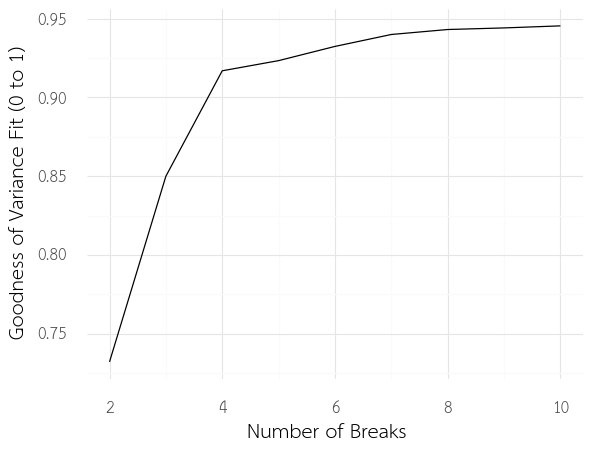

<ggplot: (8767725357204)>

In [5]:
g = (ggplot(elbow, aes(x='breaks',y='gvf',group=1)) + geom_line() +
    xlab('Number of Breaks') + ylab('Goodness of Variance Fit (0 to 1)'))
g

In [6]:
opt_breaks = jenkspy.jenks_breaks(budgets,4)
[i/1e9 for i in opt_breaks]

[8.7e-06, 7.8, 26.2021344, 55.0, 100.0]

### `log_budget` as Regression Target

Another alternative is to frame it as a regression table but perform Box-cox transformation to make the budget distribution more normal. We can see that the coefficient of boxcox plot peaked at labmda = 0, meaning a log transformation is optimal for transforming budget to be more normal.

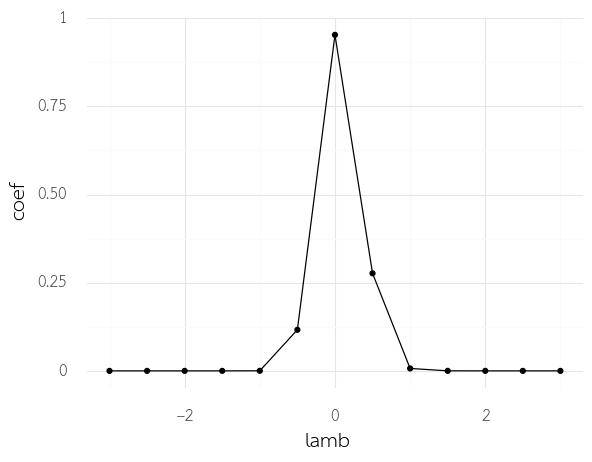

<ggplot: (8767725894092)>

In [8]:
boxcox_plot(thaime,'budget')

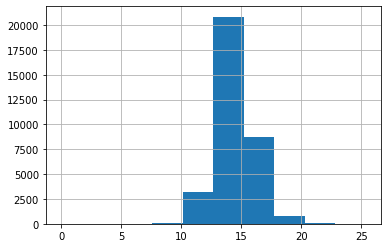

In [19]:
thaime['log_budget'] = boxcox(thaime.budget,0)
thaime = thaime.drop('budget',1)
thaime.log_budget.hist()

In [20]:
#MSE when predicting mean
np.mean((thaime.log_budget - thaime.log_budget.mean())**2)

2.626345322336116

In [39]:
thaime = thaime.reset_index(drop=True)
thaime

,project_name,unit,ministry,log_budget,test_flag
0,โครงการพื้นที่ท่องที่ยวปลอดภัยส าหรับนักท่องเท...,กรมการท่องเที่ยว,การท่องเที่ยวและกีฬา,16.117225,1
1,พัฒนาระบบโครงสร้างพื้นฐานด้านการท่องเที่ยวเพื่...,องค์การสวนพฤกษศาสตร์,ทรัพยากรธรรมชาติและสิ่งแวดล้อม,16.995134,1
2,การแปลงเครื่องจักรเป็นทุนโดยการบำรุงรักษาเครื่...,กรมโรงงานอุตสาหกรรม,อุตสาหกรรม,17.504173,0
3,การแปลงเครื่องจักรเป็นทุนโดยการบำรุงรักษาเครื่...,กรมโรงงานอุตสาหกรรม,อุตสาหกรรม,17.504173,0
4,"โครงการกำหนดแนวทางการออกแบบ ""เมืองท่องเที่ยว"" ...",กรมการท่องเที่ยว,การท่องเที่ยวและกีฬา,17.727360,0
...,...,...,...,...,...
33685,โครงการ พัฒนาป่าไม้ สร้างงาน สร้างรายได้ เพื่อ...,กรมป่าไม้,ทรัพยากรธรรมชาติและสิ่งแวดล้อม,20.224815,0
33686,โครงการ 1 ตำบล 1 กลุ่มเกษตรทฤษฎีใหม่,สำนักงานปลัดกระทรวงเกษตรและสหกรณ์ และกรมชลประทาน,เกษตรและสหกรณ์,23.384631,0
33687,โครงการเฝ้าระวังสร้างแนวกันไฟสร้างรายได้ชุมชน,กรมอุทยานแห่งชาติ สัตว์ป่า และพันธุ์พืช,ทรัพยากรธรรมชาติและสิ่งแวดล้อม,19.323644,0
33688,โครงการพัฒนาพื้นที่ต้นแบบการพัฒนาคุณภาพชีวิตตา...,กรมการพัฒนาชุมชน,มหาดไทย,22.458806,0


## Train-test split

We perform 85/15 split for train (and dev) set and test set. The benchmark is calculated by mean squared error of the test set (codes must be shown to avoid overfitting test set). Seed is 1412.

In [40]:
np.random.seed(1412)
test_idx = np.random.choice(thaime.index,size=int(thaime.shape[0]*0.15), replace=False)
thaime['test_flag'] = 0
thaime.iloc[test_idx,4] = 1
thaime.test_flag.value_counts()

0    28637
1     5053
Name: test_flag, dtype: int64

In [42]:
#check stats
thaime.groupby('test_flag').log_budget.describe()

,count,mean,std,min,25%,50%,75%,max
test_flag,,,,,,,,
0,28637.0,14.274049,1.621978,0.000000,13.090462,13.987193,15.408677,24.730599
1,5053.0,14.264001,1.613065,7.170888,13.092525,13.947679,15.394757,25.328436


In [44]:
thaime.to_csv('data/thaimaimeex.csv',index=False)